In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/reanalysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import time

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

import sys
sys.path.append(base_dir)
from utils import split_obs, plot_results

import sys
sys.path.append(base_dir+'train/kerastuner_hpsearch/')
from tfexp_hp import get_hp

2025-01-31 11:14:01.427517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-31 11:14:02.956328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


In [3]:
EXP_NAME_DATA = 'exp_data_retrain'
hps_retrain = get_hp(EXP_NAME_DATA)

print('Training Years: '+str(hps_retrain['train_yrs']))
print('Validation Years: '+str(hps_retrain['val_yrs']))
print('Testing Years: '+str(hps_retrain['test_yrs']))
print('Lead: '+str(hps_retrain['LEAD']))
print('Region: '+str(hps_retrain['region'][0])+'N x '+str(hps_retrain['region'][1])+'E')

X2train, X2val, _, Y2train, Y2val, _= split_obs(trainyrs=hps_retrain['train_yrs'],
                                                valyrs=hps_retrain['val_yrs'],
                                                testyrs=hps_retrain['test_yrs'],
                                                months=[11,12,1,2],
                                                lead=hps_retrain['LEAD'],
                                                latpt = hps_retrain['region'][0],
                                                lonpt = hps_retrain['region'][1]) # 330 or 210

X2val = X2val.reshape((X2val.shape[0],X2val.shape[1]*X2val.shape[2]))
X2train = X2train.reshape((X2train.shape[0],X2train.shape[1]*X2train.shape[2]))
input_shape = X2train.shape[1]

Training Years: [1996, 2015]
Validation Years: [2015, 2020]
Testing Years: [2020, 2023]
Lead: 14
Region: [30, 60]N x [170, 240]E


In [4]:
# ---------- ANN Hyperparameters ----------
EXP_NAME_RETRAIN = 'exp_2.1.BO_retrain'
hps_kt_retrain = get_hp(EXP_NAME_RETRAIN)

NLABEL = 2
N_EPOCHS = 1000
dropout = True
PATIENCE = hps_kt_retrain['PATIENCE']
GLOBAL_SEED = hps_kt_retrain['GLOBAL_SEED']

EXP_NAME = 'exp2' # og model
ANN1_HIDDENS = [128]

HIDDENS = hps_kt_retrain['HIDDENS'] # ONLY IF SECOND LAYER!
BATCH_SIZES = hps_kt_retrain['BATCH_SIZES']
LR_INITS = hps_kt_retrain['LR_INITS']
DROPOUT_RATES = hps_kt_retrain['DROPOUT_RATES']
RIDGES = hps_kt_retrain['RIDGES']
ALPHA = hps_kt_retrain['BO_ALPHA']
BETA = hps_kt_retrain['BO_BETA']

In [6]:
print(HIDDENS, BATCH_SIZES, LR_INITS, DROPOUT_RATES, RIDGES, ALPHA, BETA)

[8, 16, 32, 128] [16, 64] [0.01, 0.001, 0.0001] [0.0, 0.5, 0.9] [0.0, 0.5, 1.0] 0.001 10


In [7]:
def kt_retrain(hp):
    tf.keras.backend.clear_session() 

    # ----- input of ann -----
    ann_input = keras.Input(shape = input_shape)

    # Number of layers (either 1 or 2)
    num_layers = hp.Choice('num_layers', values=[1, 2])

    x = tf.keras.layers.Dense(ANN1_HIDDENS[0], 
                              activation = 'relu',
                              use_bias = True, 
                              kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=hp.Choice('l2',values=RIDGES)),
                              bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                              kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                              )(ann_input)
    if dropout:
        x = layers.Dropout(rate = hp.Choice('dropout',values=DROPOUT_RATES))(x)
    
    if num_layers == 2:
        x = tf.keras.layers.Dense(hp.Choice('units2',values=HIDDENS), 
                                  activation = 'relu',
                                  use_bias = True, 
                                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                  bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                  kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                  )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(NLABEL,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')

    # ----- load and assign original manuscript ann1 weights -----
    annfi_name = 'ann1_e3sm_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann1 = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    ann.layers[1].set_weights(ann1.layers[1].get_weights())

    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=LR_INITS),)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    ann.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)
    
    return ann

Trial 100 Complete [00h 00m 06s]
val_loss: 0.5778244137763977

Best val_loss So Far: 0.5490053296089172
Total elapsed time: 00h 14m 53s
Elapsed time during fit = 893.09 seconds

Best Trial ID: 009
Number of Layers: 2
First Layer: 128
Second Layer: 8
Learning Rate: 0.001
Dropout: 0.0
Batch Size: 64


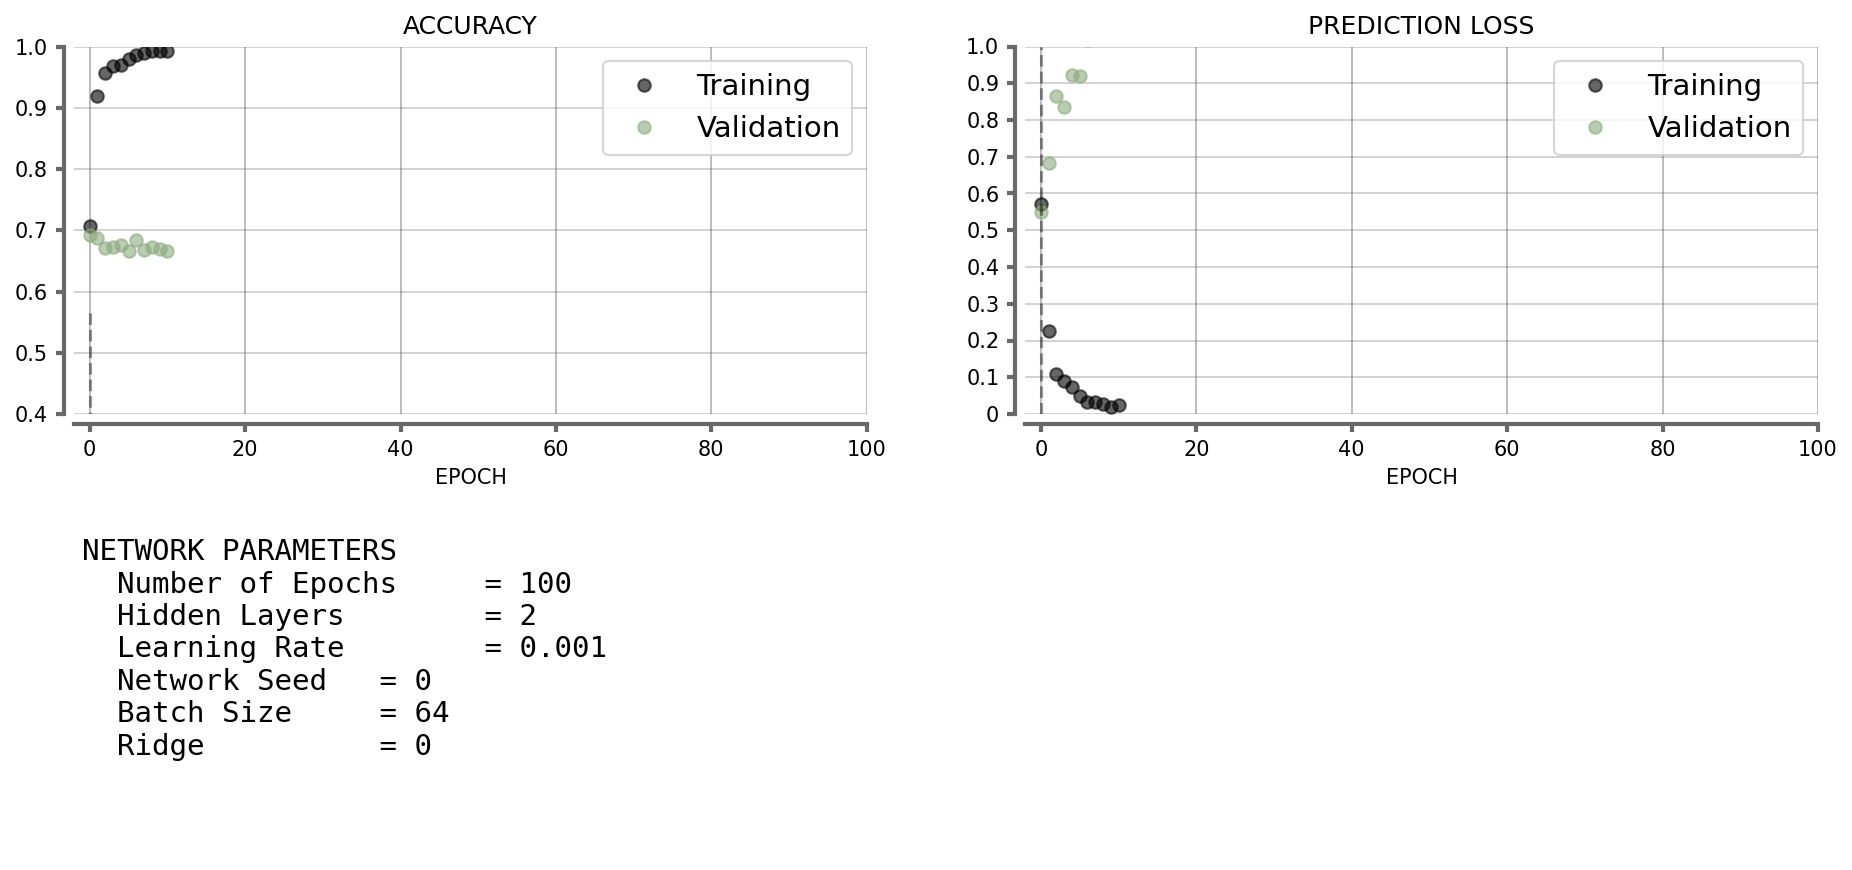

Best Trial ID: 019
Number of Layers: 2
First Layer: 128
Second Layer: 128
Learning Rate: 0.0001
Dropout: 0.9
Batch Size: 64


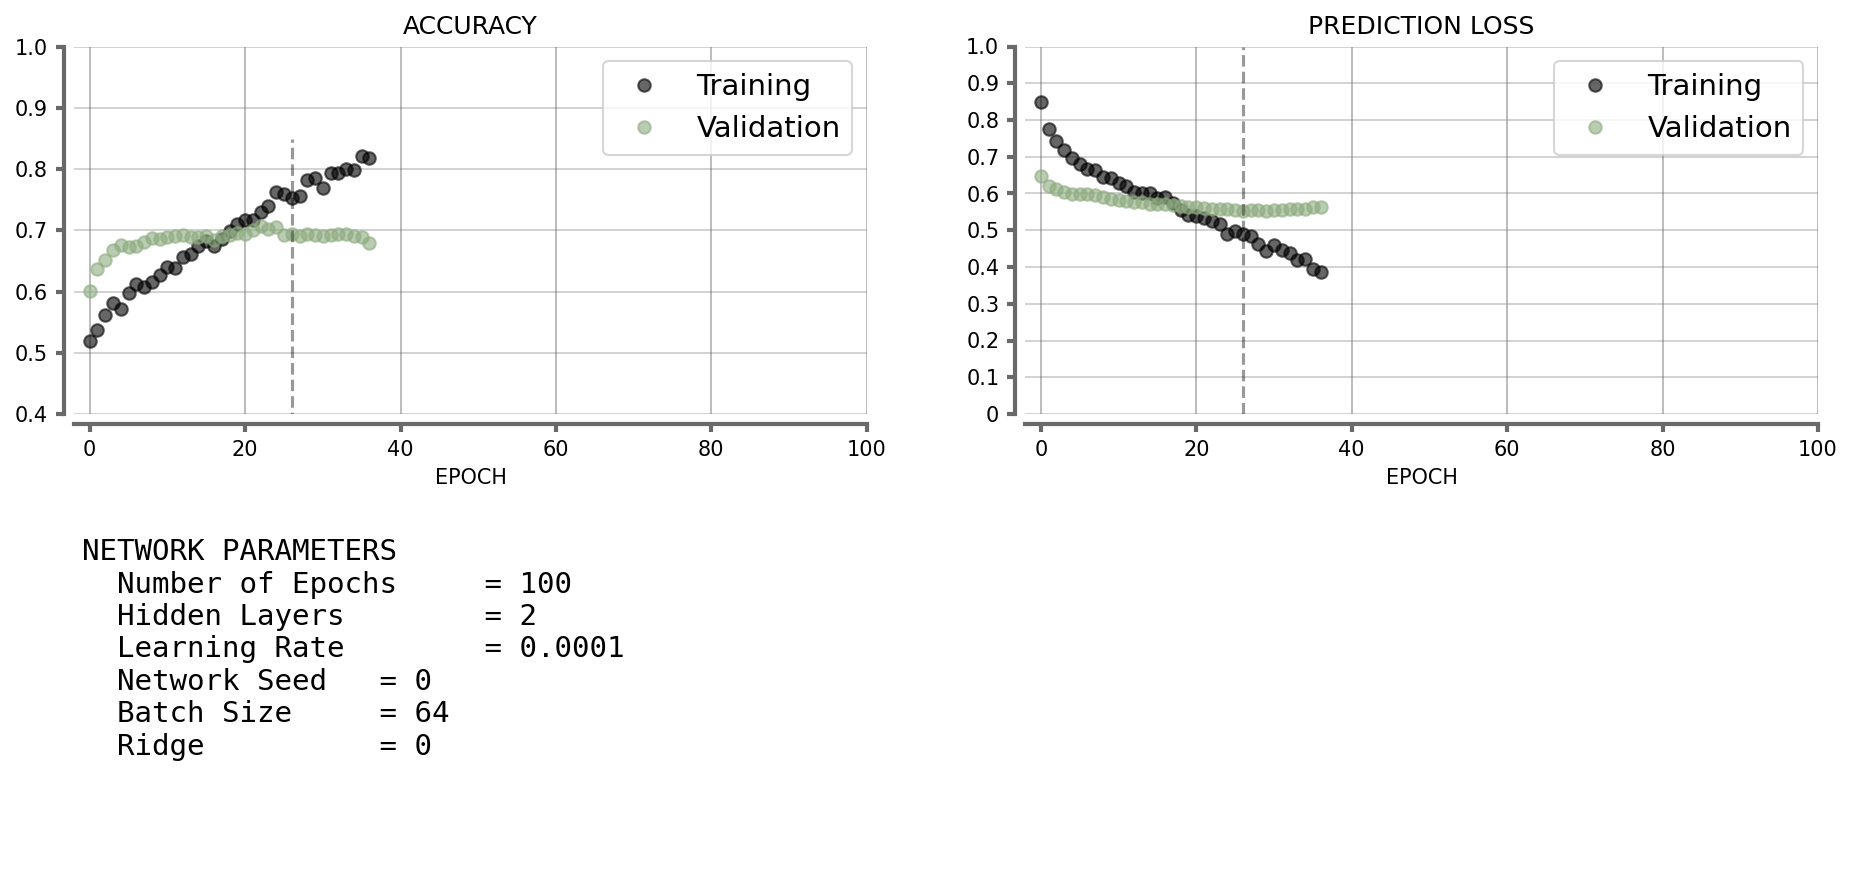

Best Trial ID: 024
Number of Layers: 2
First Layer: 128
Second Layer: 8
Learning Rate: 0.0001
Dropout: 0.0
Batch Size: 64


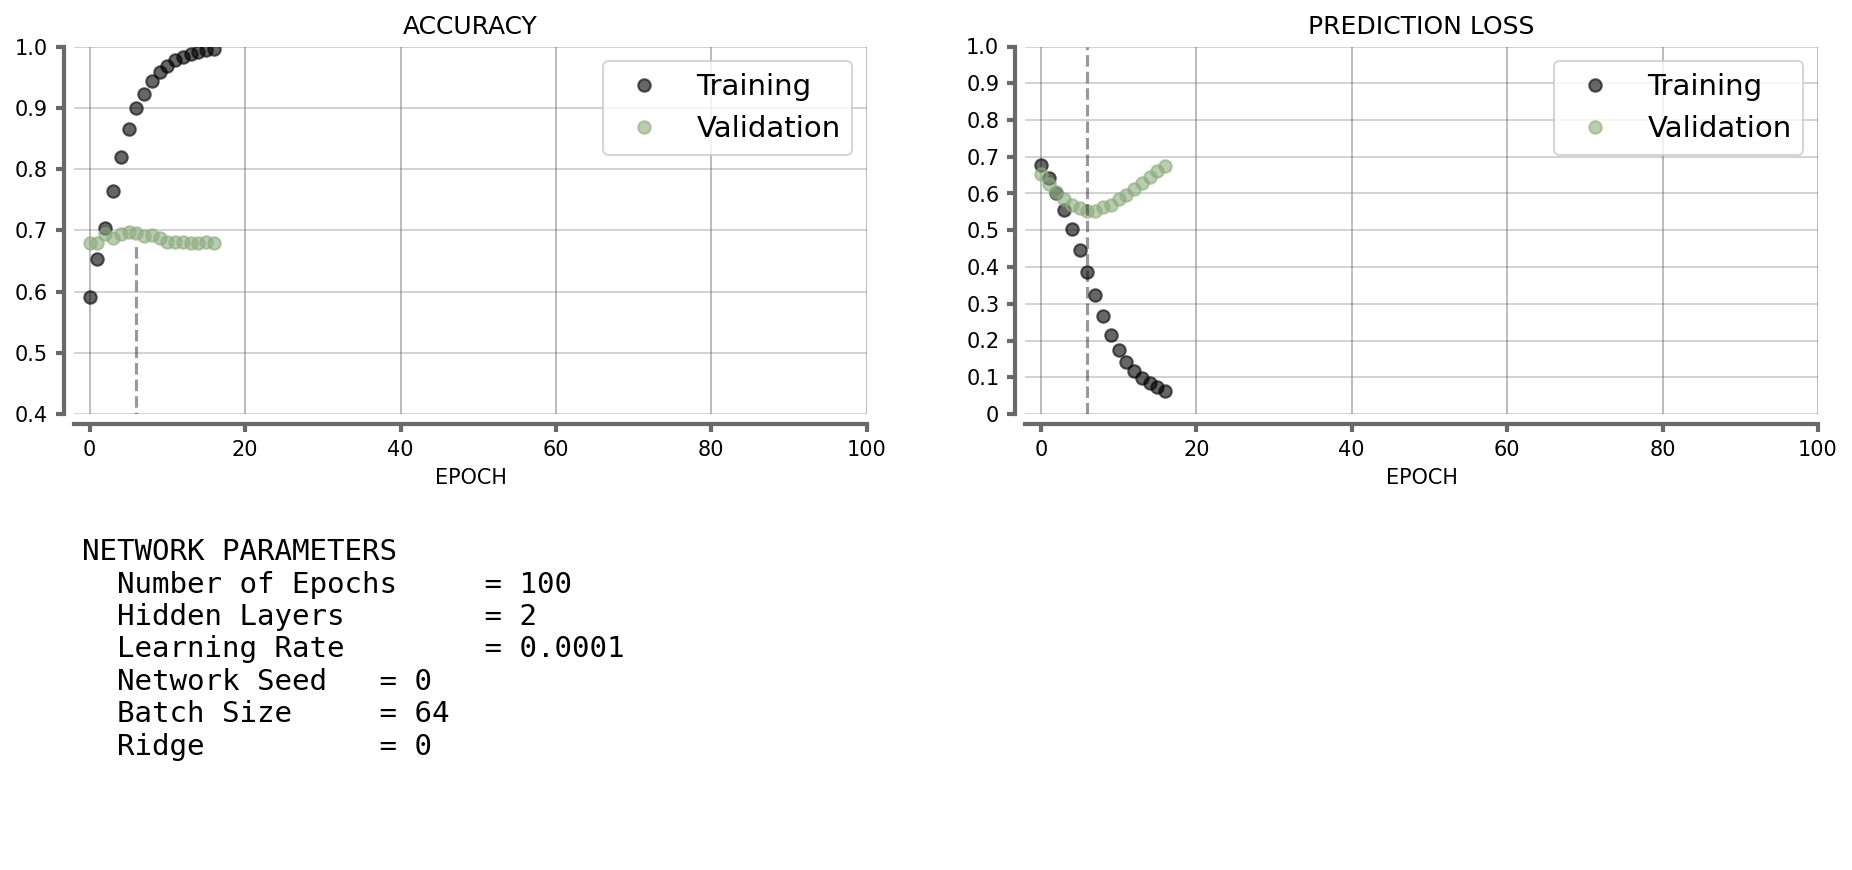

Best Trial ID: 046
Number of Layers: 2
First Layer: 128
Second Layer: 8
Learning Rate: 0.001
Dropout: 0.9
Batch Size: 64


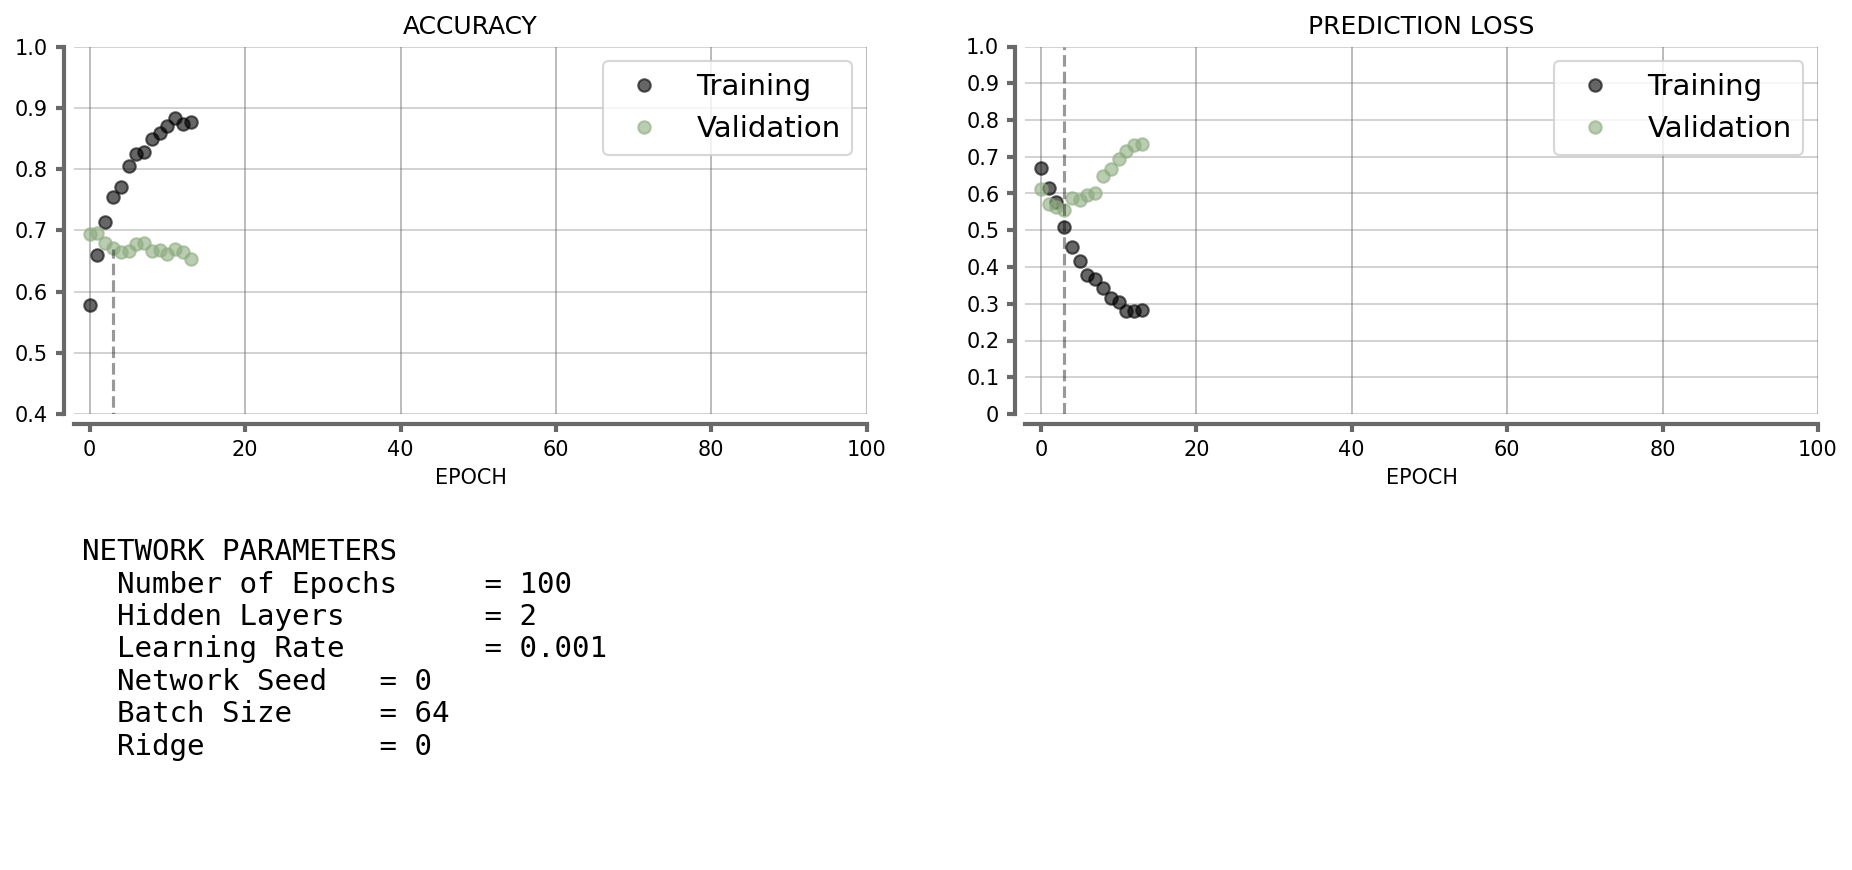

Best Trial ID: 033
Number of Layers: 2
First Layer: 128
Second Layer: 8
Learning Rate: 0.0001
Dropout: 0.5
Batch Size: 64


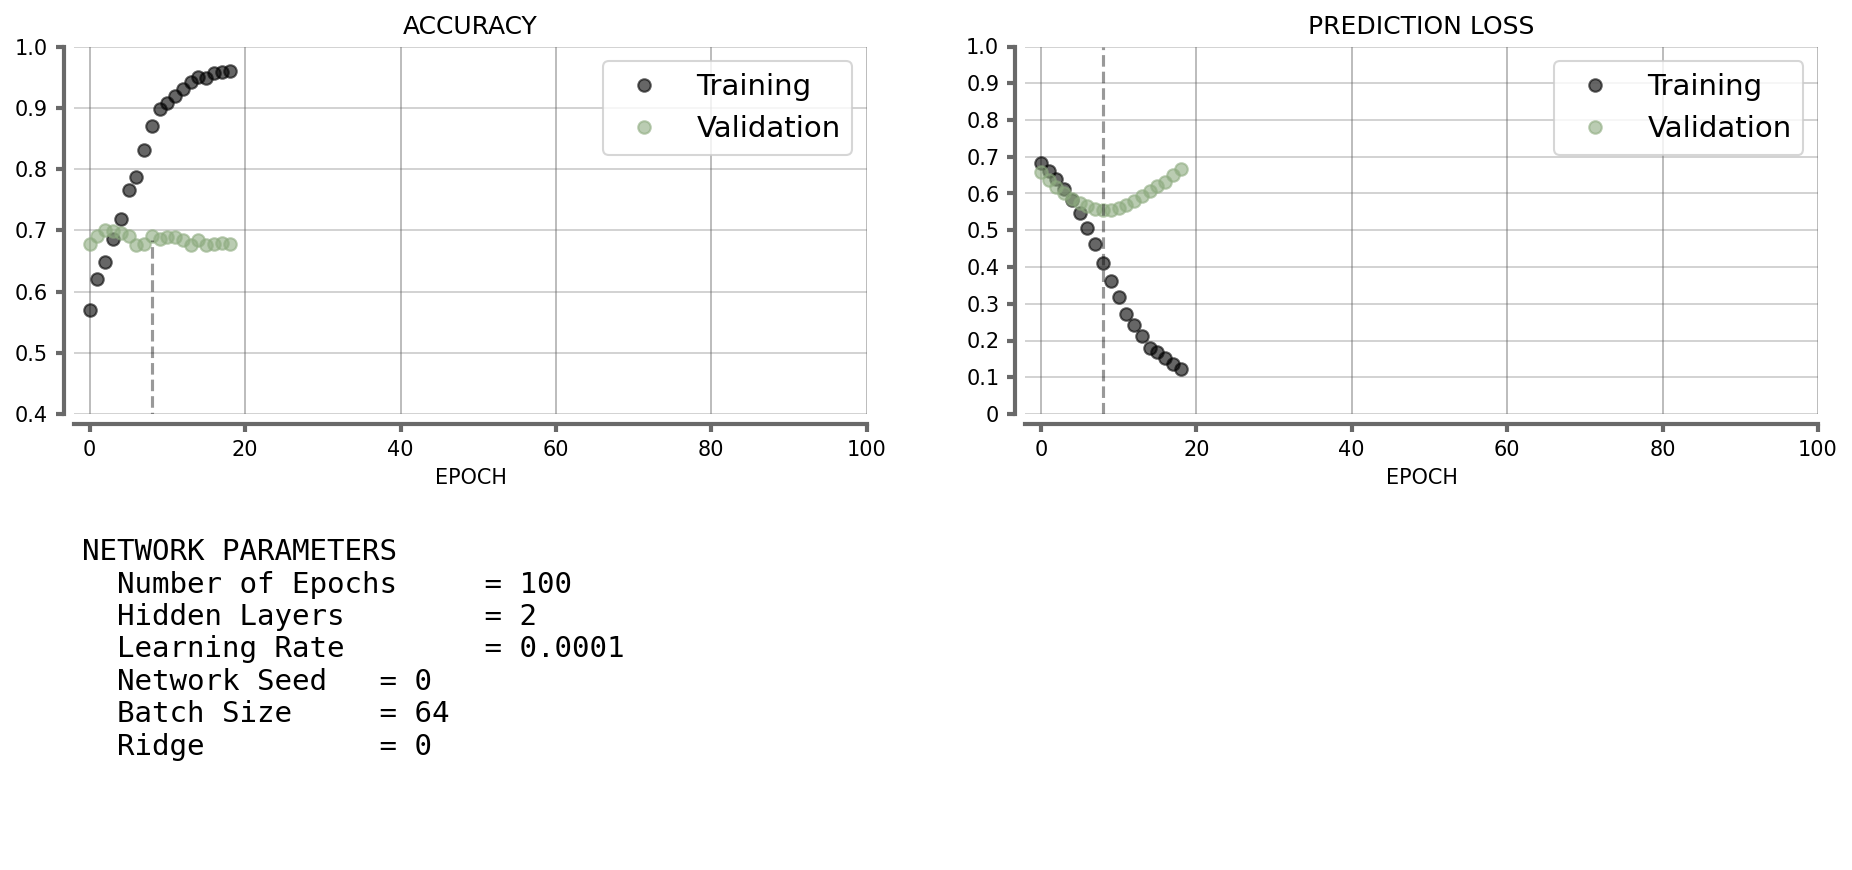

In [8]:
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
SEED = 0

for BATCH_SIZE in BATCH_SIZES:
    tuner = kt.BayesianOptimization(kt_retrain,
                                    objective='val_loss',
                                    max_trials=100,
                                    alpha=ALPHA,
                                    beta=BETA, # more explorative than default=2.6
                                    directory='hp_results',
                                    project_name='hp_exp'+EXP_NAME_RETRAIN[4:]+'.'+str(BATCH_SIZE))

    # ----- Callbacks -----
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    start_time = time.time()
    tuner.search(X2train,Y2train,
                 validation_data = [X2val,Y2val],
                 epochs = N_EPOCHS,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = [ES])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=5)
    for b_hps in range(len(best_hps)):
        trial_id = tuner.oracle.get_best_trials(num_trials=5)[b_hps].trial_id
        print(f"""Best Trial ID: {trial_id}""")
        print(f"""Number of Layers: {best_hps[b_hps].get('num_layers')}""")
        print(f"""First Layer: {128}""")
        if best_hps[b_hps].get('num_layers') == 2:
            print(f"""Second Layer: {best_hps[b_hps].get('units2')}""")
        print(f"""Learning Rate: {best_hps[b_hps].get('learning_rate')}""")
        print(f"""Dropout: {best_hps[b_hps].get('dropout')}""")
        print(f"""Batch Size: {BATCH_SIZE}""")
        
        best_model = tuner.hypermodel.build(best_hps[b_hps])

        history = best_model.fit(X2train, Y2train,
                                 validation_data = [X2val,Y2val],
                                 epochs = N_EPOCHS,
                                 batch_size = BATCH_SIZE,
                                 shuffle = True,
                                 verbose=0,
                                 callbacks = [ES])
        
        #----- PLOT THE RESULTS -----
        plot_results(
            history,
            exp_info=(100, best_hps[b_hps].get('num_layers'), best_hps[b_hps].get('learning_rate'), BATCH_SIZE, SEED, PATIENCE, 0),
            showplot=True
        ) 
    
        annfi_name = 'ann2_obs_'+EXP_NAME_RETRAIN+'_'+str(BATCH_SIZE)+'_modelnum'+str(b_hps+1)+'outof5_seed'+str(SEED)+'.h5'
        best_model.save(base_dir+'train/kerastuner_hpsearch/hp_results/hp_exp2.1.BO_retrain_models/'+annfi_name)  